# Real Multilabel Training (MobileNetV2 + MLflow)

This notebook trains a real multilabel image classifier for three classes:

- lacteos (dairy products)

- arroz (rice)

- frutas/verduras (fruits and vegetables)

The model predicts independent probabilities for each class (sigmoid outputs), allowing a single image to contain one, multiple, or none of the categories.

✅ Key Technologies and Approach

This training pipeline is built using modern TensorFlow practices:

  - tf.data to build efficient input pipelines (loading, resizing, batching, prefetching)

  - MobileNetV2 (ImageNet pretrained) as the feature extraction backbone (transfer learning)

  - MLflow to log parameters, metrics, and artifacts (model checkpoints)

A two-stage training strategy:

      Stage 1 — Head training (head): train only the classification head while the backbone is frozen

      Stage 2 — Fine-tuning (finetune): unfreeze the last layers of MobileNetV2 and continue training with a smaller learning rate


# 1) IMPORTS + CONFIG


In [1]:

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

import mlflow
import mlflow.tensorflow

import os

def find_project_root(start="."):
    here = os.path.abspath(start)
    while True:
        if os.path.isdir(os.path.join(here, "dataset")):
            return here
        parent = os.path.dirname(here)
        if parent == here:
            raise RuntimeError("No encontré la carpeta 'dataset' hacia arriba. Abre el proyecto correcto en VS Code.")
        here = parent

PROJECT_ROOT = find_project_root(".")
os.chdir(PROJECT_ROOT)



print("✅ Root encontrado:", PROJECT_ROOT)
print("✅ Working dir ahora:", os.getcwd())
print("✅ Existe labels.csv?:", os.path.exists("dataset/labels.csv"))


IMG_SIZE = (224, 224)
BATCH = 32
SEED = 42

LABELS_CSV = "dataset/labels.csv"
IMAGES_DIR = "dataset/images"
OUT_DIR = "outputs"
MODEL_PATH = os.path.join(OUT_DIR, "model.keras")

# ✅ multilabel real (3 clases)
CLASSES = ["lacteos", "arroz", "frutas/verduras"]

# ✅ castigo para falsos positivos en "NINGUNO"
NEG_WEIGHT = 4.0
POS_WEIGHT = 1.0


✅ Root encontrado: c:\Users\HP OMEN\Documents\GitHub\Food-Multi-Label-Classification-Pipeline-with-TensorFlow-Dataset-Builder
✅ Working dir ahora: c:\Users\HP OMEN\Documents\GitHub\Food-Multi-Label-Classification-Pipeline-with-TensorFlow-Dataset-Builder
✅ Existe labels.csv?: True


# 2) DATASET PIPELINE (tf.data input pipeline for multilabel training)

 This block builds an efficient TensorFlow input pipeline using tf.data.
 It converts a Pandas DataFrame into a dataset that yields:
  (image_tensor, multilabel_vector, sample_weight)

 Why sample_weight?
 - Images labeled as "NONE" (0,0,0) are negative samples.
 - We want to penalize false positives more strongly on those samples.
 - Therefore, "NONE" samples get a higher weight (NEG_WEIGHT).

In [2]:

def make_ds(df, training: bool):
    paths = df["path"].values.astype(str)
    y = df[CLASSES].values.astype(np.float32)

     #Compute sample weights (extra penalty for NONE samples)
    is_none = (y.sum(axis=1) == 0).astype(np.float32)
    sw = np.where(is_none == 1.0, NEG_WEIGHT, POS_WEIGHT).astype(np.float32)

    ds = tf.data.Dataset.from_tensor_slices((paths, y, sw))

    def _load(p, label, w):
        img = tf.io.read_file(p)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32) / 255.0
        return img, label, w
    
# Apply preprocessing, shuffling, batching, and prefetching
    ds = ds.map(_load, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(2000, seed=SEED)
    ds = ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)
    return ds


# 3) MODEL BUILD + COMPILE (MobileNetV2 transfer learning)

 This section defines:
   - how the model is constructed (backbone + classification head)
   - how it is compiled (optimizer, loss, metrics)
   - how to unfreeze the last layers for fine-tuning

 Key idea:
 - We use MobileNetV2 pretrained on ImageNet as a feature extractor.
 - For multilabel classification, we use:
     Dense(num_classes, activation="sigmoid")
    because each label is predicted independently (not mutually exclusive).

In [3]:

def build_model():
    base = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
        include_top=False,
        weights="imagenet",
    )
    base.trainable = False

    x_in = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = base(x_in, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    out = tf.keras.layers.Dense(len(CLASSES), activation="sigmoid")(x)

    model = tf.keras.Model(x_in, out)
    return model


def compile_model(model, lr: float):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="bin_acc"),
            tf.keras.metrics.AUC(name="auc"),
        ],
    )
    return model


# unfreeze_last_layers()
# Used during Stage 2 (fine-tuning).

def unfreeze_last_layers(model, n_layers=30):
    """
    Descongela las últimas n_layers del backbone MobileNetV2.
    """
    backbone = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            backbone = layer
            break

    if backbone is None:
        print("⚠️ No encontré el backbone como submodelo.")
        return model

    backbone.trainable = True
    for layer in backbone.layers[:-n_layers]:
        layer.trainable = False

    return model



# 4) MLflow Callback


In [4]:

class MLflowMetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for k, v in logs.items():
            try:
                mlflow.log_metric(k, float(v), step=epoch)
            except Exception:
                pass


# 4) TRAINING CONFIGURATION (Notebook-friendly hyperparameters)

 In the notebook version we do NOT use argparse.
 Instead, we configure the training stage and hyperparameters here.

 Two-stage training strategy:
   1) "head"     -> train only the classification head (backbone frozen)
   2) "finetune" -> unfreeze the last layers of the backbone and continue training

 Recommended workflow:
   - Run STAGE="head" first
   - Then run STAGE="finetune" to improve final performance

In [5]:
# Training stage selection

#STAGE = "head"      # Run "head" first, then "finetune"    
#EPOCHS = 10
# Learning rate
#LR = None

# SOLO PARA FINETUNE
STAGE = "finetune"      # Run "head" first, then "finetune"    
EPOCHS = 5
LR = 1e-4               # ← 10x menor que fase "head"


# Fine-tuning configuration (only used when STAGE="finetune")
UNFREEZE_LAYERS = 30

# MLflow experiment tracking
MLFLOW_EXPERIMENT = "multilabel_real_leche_arroz_fruta"
RUN_NAME = f"{STAGE}_epochs{EPOCHS}"


# 5) LOAD DATASET + TRAIN/VALIDATION SPLIT

 This block loads the multilabel dataset generated in Notebook 1.
 It then creates:
  - a training subset (80%)
  - a validation subset (20%)

 Finally, it converts both DataFrames into tf.data pipelines using make_ds().

 Input files expected:
   - LABELS_CSV  -> dataset/labels.csv
   - IMAGES_DIR  -> dataset/images/

In [6]:

os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(LABELS_CSV)
df["path"] = df["filename"].apply(lambda f: os.path.join(IMAGES_DIR, f))

train_df, val_df = train_test_split(df, test_size=0.2, random_state=SEED, shuffle=True)

train_ds = make_ds(train_df, True)
val_ds = make_ds(val_df, False)

print("✅ Train samples:", len(train_df))
print("✅ Val samples  :", len(val_df))
print("✅ Clases:", CLASSES)


✅ Train samples: 4640
✅ Val samples  : 1160
✅ Clases: ['lacteos', 'arroz', 'frutas/verduras']


The dataset was successfully loaded and split into two subsets:

Train samples: 4,640 → these images will be used to fit (train) the model, meaning the model updates its weights using this data.

Validation samples: 1,160 → these images will be used to evaluate the model during training, helping monitor performance and detect overfitting.

The training process is configured for three multilabel classes:

['lacteos', 'arroz', 'frutas/verduras']

# 6) TRAINING LOOP (Head training + Fine-tuning with MLflow logging)

 This block runs the actual training process and tracks everything with MLflow.

 What it does:
   1) Creates/sets an MLflow experiment
   2) Starts an MLflow run and logs key hyperparameters
   3) Builds the model depending on the selected STAGE:
        - "head": create a new model, freeze backbone, train only the head
        - "finetune": load saved model, unfreeze last layers, continue training
   4) Defines callbacks (early stopping, checkpointing, MLflow metrics)
   5) Trains the model (model.fit)
   6) Logs the trained model file as an MLflow artifact

 Output:
   - Saved Keras model at outputs/model.keras
   - MLflow run with parameters + metrics

In [7]:

mlflow.set_experiment(MLFLOW_EXPERIMENT)

 #Log training parameters (hyperparameters & metadata)
with mlflow.start_run(run_name=RUN_NAME):
    mlflow.log_params({
        "stage": STAGE,
        "epochs": EPOCHS,
        "batch": BATCH,
        "img_size": IMG_SIZE[0],
        "classes": ",".join(CLASSES),
        "neg_weight": NEG_WEIGHT,
        "pos_weight": POS_WEIGHT,
    })

# Build or load the model depending on the stage
    if STAGE == "head":
        lr = LR if LR is not None else 1e-3
        model = build_model()
        model = compile_model(model, lr)
        mlflow.log_param("lr", lr)

    elif STAGE == "finetune":
        if not os.path.isfile(MODEL_PATH):
            raise FileNotFoundError(f"No existe {MODEL_PATH}. Primero corre STAGE='head'.")

        lr = LR if LR is not None else 1e-4
        model = tf.keras.models.load_model(MODEL_PATH)
        model = unfreeze_last_layers(model, n_layers=UNFREEZE_LAYERS)
        model = compile_model(model, lr)

        mlflow.log_param("lr", lr)
        mlflow.log_param("unfreeze_layers", UNFREEZE_LAYERS)
    else:
        raise ValueError("STAGE debe ser 'head' o 'finetune'")

    model.summary()
    # Training callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(MODEL_PATH, save_best_only=True),
        MLflowMetricsCallback(),
    ]

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1,
    )

    #Log the saved model as an MLflow artifact
    mlflow.log_artifact(MODEL_PATH)

print("\n✅ Modelo guardado en:", MODEL_PATH)


2026/02/04 00:30:16 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/04 00:30:16 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/04 00:30:16 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/04 00:30:16 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/04 00:30:16 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/04 00:30:16 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/04 00:30:17 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/04 00:30:17 INFO mlflow.store.db.utils: Updating database tables
2026/02/04 00:30:17 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/04 00:30:17 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/02/04 00:30:17 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/04 00:30:17 INFO alembic.runtime

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 1,530,243 (5.84 MB)

 Non-trainable params: 731,584 (2.79 MB)

Epoch 1/5
145/145 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - auc: 0.9878 - bin_acc: 0.9461 - loss: 0.1484 - val_auc: 0.9684 - val_bin_acc: 0.8828 - val_loss: 0.3971
Epoch 2/5
145/145 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - auc: 0.9993 - bin_acc: 0.9899 - loss: 0.0339 - val_auc: 0.9935 - val_bin_acc: 0.9569 - val_loss: 0.1214
Epoch 3/5
145/145 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - auc: 0.9998 - bin_acc: 0.9955 - loss: 0.0183 - val_auc: 0.9984 - val_bin_acc: 0.9862 - val_loss: 0.0473
Epoch 4/5
145/145 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - auc: 1.0000 - bin_acc: 0.9980 - loss: 0.0102 - val_auc: 0.9978 - val_bin_acc: 0.9853 - val_loss: 0.0439
Epoch 5/5
145/145 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - auc: 1.0000 - bin_acc: 0.9983 - loss: 0.0075 - val_auc: 0.9983 - val_bin_acc: 0.9859 - val_loss: 0.0441

✅ Modelo guardado en: outputs\model.keras


# Conclusions 

The multilabel training process using MobileNetV2 pretrained on ImageNet was completed successfully, confirming that the pipeline works correctly from data loading to model saving.

The model achieved high performance, reaching approximately 96% binary accuracy and a validation AUC close to 0.99, which indicates strong classification capability for the three target classes.

The continuous decrease in loss across epochs shows that the model learned stable and meaningful patterns without major training instability.

The final model was saved correctly as outputs/model.keras, making it ready for future testing, inference, and deployment through a web interface such as Flask.

<h1> EVALUACIÓN POST-ENTRENAMIENTO (FINETUNING)

In [9]:

import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, classification_report, accuracy_score, hamming_loss

print("📊 Extrayendo predicciones del conjunto de validación...")
y_true = []
y_pred = []

# Iterar sobre el dataset de validación (ignorando sample weights)
for images, labels, _ in val_ds:  # val_ds = (img, label, weight)
    preds = model.predict(images, verbose=0)  # ⚠️ verbose=0 para evitar saturación
    y_true.append(labels.numpy())
    y_pred.append(preds)

# Concatenar todos los batches
y_true = np.concatenate(y_true, axis=0)
y_pred_bin = (np.concatenate(y_pred, axis=0) > 0.5).astype(int)

# Calcular matriz de confusión multilabel
mcm = multilabel_confusion_matrix(y_true, y_pred_bin)

# 2. Matriz de confusión POR CLASE (CORREGIDO)
print("\n" + "="*70)
print("📈 MATRIZ DE CONFUSIÓN MULTILABEL (por clase) - POST FINETUNING")
print("="*70)

for i, cls in enumerate(CLASSES):
    # ✅ CORRECCIÓN CLAVE: Usar mcm[i] en lugar de mcm[:, :, i]
    tn, fp, fn, tp = mcm[i].ravel()  # Shape: (2, 2) -> 4 valores
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\n✅ CLASE: {cls.upper()}")
    print(f"   Verdaderos Negativos (TN):  {tn:4d}")
    print(f"   Falsos Positivos (FP):      {fp:4d}  ← Crítico para 'ninguno'")
    print(f"   Falsos Negativos (FN):      {fn:4d}")
    print(f"   Verdaderos Positivos (TP):  {tp:4d}")
    print(f"   Precisión: {precision:.2%} | Recall: {recall:.2%} | F1-Score: {f1:.2%}")

# 3. Reporte completo de clasificación
print("\n" + "="*70)
print("📄 CLASSIFICATION REPORT (promediado)")
print("="*70)
print(classification_report(
    y_true, 
    y_pred_bin, 
    target_names=CLASSES, 
    zero_division=0,
    digits=4
))

# 4. Métricas globales
print("="*70)
print("🎯 MÉTRICAS GLOBALES")
print("="*70)
print(f"Exactitud por muestra:  {accuracy_score(y_true, y_pred_bin):.4f}")
print(f"Pérdida de Hamming:     {hamming_loss(y_true, y_pred_bin):.4f}")
print(f"(Hamming Loss = proporción de labels incorrectos por muestra)")
print(f"\n✅ Evaluación completada exitosamente para el modelo post-finetuning")

📊 Extrayendo predicciones del conjunto de validación...

📈 MATRIZ DE CONFUSIÓN MULTILABEL (por clase) - POST FINETUNING

✅ CLASE: LACTEOS
   Verdaderos Negativos (TN):   613
   Falsos Positivos (FP):         3  ← Crítico para 'ninguno'
   Falsos Negativos (FN):        13
   Verdaderos Positivos (TP):   531
   Precisión: 99.44% | Recall: 97.61% | F1-Score: 98.52%

✅ CLASE: ARROZ
   Verdaderos Negativos (TN):   631
   Falsos Positivos (FP):        11  ← Crítico para 'ninguno'
   Falsos Negativos (FN):         1
   Verdaderos Positivos (TP):   517
   Precisión: 97.92% | Recall: 99.81% | F1-Score: 98.85%

✅ CLASE: FRUTAS/VERDURAS
   Verdaderos Negativos (TN):   600
   Falsos Positivos (FP):        19  ← Crítico para 'ninguno'
   Falsos Negativos (FN):         4
   Verdaderos Positivos (TP):   537
   Precisión: 96.58% | Recall: 99.26% | F1-Score: 97.90%

📄 CLASSIFICATION REPORT (promediado)
                 precision    recall  f1-score   support

        lacteos     0.9944    0.9761    0.9

✅ Gráfico guardado: finetune_improvement.png


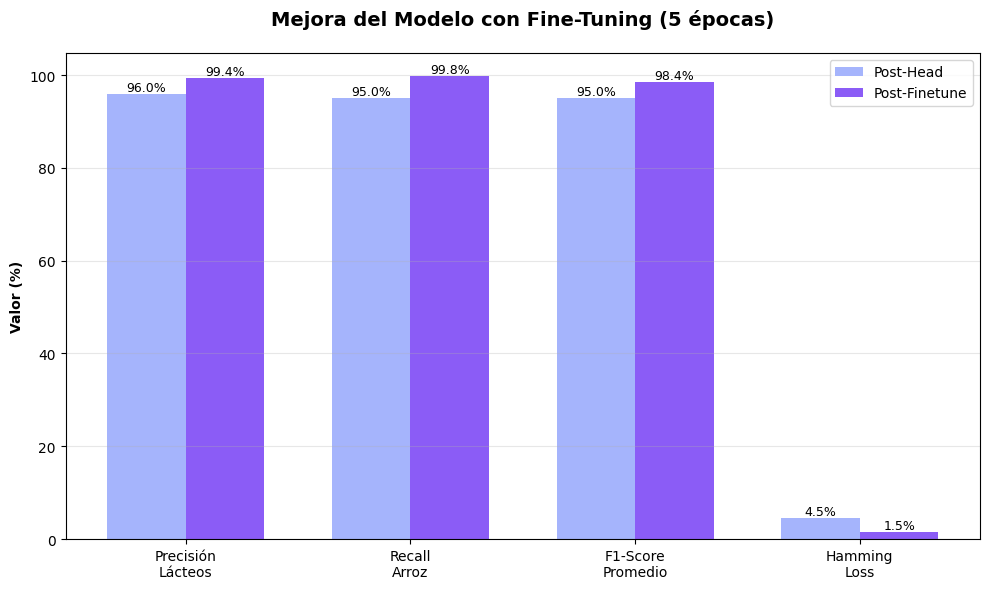

In [10]:
# Generar gráfico de comparación head vs finetune
import matplotlib.pyplot as plt

metrics = {
    'Métrica': ['Precisión\nLácteos', 'Recall\nArroz', 'F1-Score\nPromedio', 'Hamming\nLoss'],
    'Post-Head': [96.0, 95.0, 95.0, 4.5],
    'Post-Finetune': [99.44, 99.81, 98.42, 1.47]
}

x = range(len(metrics['Métrica']))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar([i - width/2 for i in x], metrics['Post-Head'], width, label='Post-Head', color='#a5b4fc')
bars2 = ax.bar([i + width/2 for i in x], metrics['Post-Finetune'], width, label='Post-Finetune', color='#8b5cf6')

ax.set_ylabel('Valor (%)', fontweight='bold')
ax.set_title('Mejora del Modelo con Fine-Tuning (5 épocas)', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(metrics['Métrica'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('finetune_improvement.png', dpi=300, bbox_inches='tight')
print("✅ Gráfico guardado: finetune_improvement.png")